In [ ]:
#| default_exp augment

# Augmentation

In [ ]:
#|export
import torch,random
import fastcore.all as fc

from torch import nn
from torch.nn import init

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *

In [ ]:
import pickle,gzip,math,os,time,shutil
import matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,optim
from torch.utils.data import DataLoader,default_collate
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from fastcore.test import test_close
from torch import distributions

torch.set_printoptions(precision=2, linewidth=180, sci_mode=False)
mpl.rcParams['image.cmap'] = 'gray_r'

import logging
logging.disable(logging.WARNING)

set_seed(1103, False)

if fc.defaults.cpus>8: fc.defaults.cpus=8

In [ ]:
fm_x, fm_y = "image", "label"
name = "fashion_mnist"
ds = load_dataset(name)

xmean = tensor(0.28)
xstd = tensor(0.35)

@inplace
def transformi(b):
    b["image"] = [(TF.to_tensor(i) - xmean) / xstd for i in b["image"]]
dst = ds.with_transform(transformi)

bs = 1024
dls = DataLoaders.from_dd(dst, bs)
xb, yb = next(iter(dls.train))

In [ ]:
stats = ActivationStats(lambda x: isinstance(x, GeneralReLU))
cbs = [DeviceCB(), stats, ProgressCB(plot=True), MetricsCB(accuracy=MulticlassAccuracy())]
init_w = partial(init_weights, leak=0.1)

## Going wider

In [ ]:
def get_model(act=act_gr, nfs=[16,32,64,128,256,512], norm=nn.BatchNorm2d):
    layers = [ResBlock(nfs[i], nfs[i+1], act=act, stride=2, norm=norm) for i in range(len(nfs)-1)]
    model = nn.Sequential(
        ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm), *layers,
        nn.Flatten(), nn.Linear(nfs[-1], 10)
    )
    return model

accuracy,loss,epoch,train
0.824,0.487,0,train
0.867,0.402,0,valid
0.879,0.323,1,train
0.874,0.359,1,valid
0.904,0.258,2,train
0.895,0.298,2,valid
0.922,0.207,3,train
0.910,0.250,3,valid
0.945,0.147,4,train
0.922,0.226,4,valid


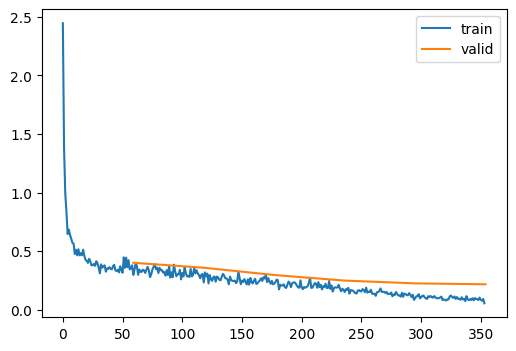

In [ ]:
epochs = 6
lr = 0.01
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))

set_seed(1103, False)
model = get_model()
model = model.apply(init_w)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[sched], opt_func=optim.AdamW)
learn.fit(epochs)

### Pooling

In [ ]:
torch.empty((2,3,4,5)).mean((-1, -2)).shape

torch.Size([2, 3])

In [ ]:
class GlobalAvgPool(nn.Module):
    def forward(self, x):
        return x.mean((-1,-2))

In [ ]:
def get_model2(act=act_gr, nfs=[16,32,64,128,256,512], norm=nn.BatchNorm2d):
    layers = [ResBlock(nfs[i], nfs[i+1], act=act, stride=2, norm=norm) for i in range(len(nfs)-2)]
    model = nn.Sequential(
        ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm), *layers,
        ResBlock(256, 512, ks=3, stride=1, act=act, norm=norm),
        GlobalAvgPool(), nn.Linear(nfs[-1], 10)
    )
    return model

In [ ]:
@fc.patch
def summary(self:Learner):
    result = "|Module|Input|Output|Num params|\n|-|-|-|-|\n"
    total = 0
    def _summary(hook, mod, inp, outp):
        nonlocal total, result
        num = sum(i.numel() for i in mod.parameters())
        result += f"|{type(mod).__name__}|{str(inp[0].shape)[11:-1]}|{str(outp.shape)[11:-1]}|{num}|\n"
        total += num

    with Hooks(self.model, _summary) as hooks:
        self.fit(1, train=False, cbs=[SingleBatchCB()])
    if fc.IN_NOTEBOOK:
        from IPython.display import Markdown
        result = Markdown(result)
    return result

In [ ]:
learn.summary()

|Module|Input|Output|Num params|
|-|-|-|-|
|ResBlock|[1024, 1, 28, 28]|[1024, 16, 28, 28]|6928|
|ResBlock|[1024, 16, 28, 28]|[1024, 32, 14, 14]|14560|
|ResBlock|[1024, 32, 14, 14]|[1024, 64, 7, 7]|57792|
|ResBlock|[1024, 64, 7, 7]|[1024, 128, 4, 4]|230272|
|ResBlock|[1024, 128, 4, 4]|[1024, 256, 2, 2]|919296|
|ResBlock|[1024, 256, 2, 2]|[1024, 512, 1, 1]|3673600|
|Flatten|[1024, 512, 1, 1]|[1024, 512]|0|
|Linear|[1024, 512]|[1024, 10]|5130|


In [ ]:
#| export
def _flops(x, h, w):
    d = x.dim()
    if d > 4:
        raise NotImplementedError()
    if d == 4:
        return h * w * x.numel()
    return x.numel()

In [ ]:
#|export
MEGA = 1000*1000

@fc.patch
def summary(self:Learner):
    result = "|Module|Input|Output|Num params|~MFLOPS|\n|-|-|-|-|-|\n"
    total = 0
    total_flops = 0
    def _summary(hook, mod, inp, outp):
        nonlocal total, result, total_flops
        num = sum(i.numel() for i in mod.parameters())
        h, w = outp.shape[-2], outp.shape[-1]
        flops = sum(_flops(p, h, w) for p in mod.parameters())
        result += f"|{type(mod).__name__}|{str(inp[0].shape)[11:-1]}|{str(outp.shape)[11:-1]}|{num}|{flops/MEGA:.1f}|\n"
        total += num
        total_flops += flops
    with Hooks(self.model, _summary) as hooks:
        self.fit(1, train=False, cbs=[SingleBatchCB()])
    print(f"TOTAL: params={total}, ~MFLOPs={total_flops/MEGA:.1f}")
    if fc.IN_NOTEBOOK:
        from IPython.display import Markdown
        result = Markdown(result)
    return result

In [ ]:
epochs = 6
lr = 0.01
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))

set_seed(1103, False)
model = get_model2()
model = model.apply(init_w)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[sched], opt_func=optim.AdamW)

In [ ]:
learn.summary()

TOTAL: params=4907578, ~MFLOPs=33.0


|Module|Input|Output|Num params|~MFLOPS|
|-|-|-|-|-|
|ResBlock|[1024, 1, 28, 28]|[1024, 16, 28, 28]|6928|5.3|
|ResBlock|[1024, 16, 28, 28]|[1024, 32, 14, 14]|14560|2.8|
|ResBlock|[1024, 32, 14, 14]|[1024, 64, 7, 7]|57792|2.8|
|ResBlock|[1024, 64, 7, 7]|[1024, 128, 4, 4]|230272|3.7|
|ResBlock|[1024, 128, 4, 4]|[1024, 256, 2, 2]|919296|3.7|
|ResBlock|[1024, 256, 2, 2]|[1024, 512, 2, 2]|3673600|14.7|
|GlobalAvgPool|[1024, 512, 2, 2]|[1024, 512]|0|0.0|
|Linear|[1024, 512]|[1024, 10]|5130|0.0|


accuracy,loss,epoch,train
0.825,0.484,0,train
0.863,0.441,0,valid
0.881,0.320,1,train
0.873,0.358,1,valid
0.907,0.253,2,train
0.883,0.329,2,valid
0.924,0.203,3,train
0.911,0.257,3,valid
0.945,0.145,4,train
0.920,0.230,4,valid


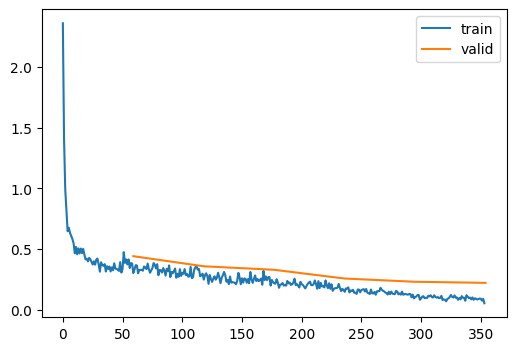

In [ ]:
learn.fit(epochs)

In [ ]:
def get_model3(act=act_gr, nfs=[16,32,64,128,256], norm=nn.BatchNorm2d):
    layers = [ResBlock(nfs[i], nfs[i+1], act=act, stride=2, norm=norm) for i in range(len(nfs)-1)]
    model = nn.Sequential(
        ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm), *layers,
        GlobalAvgPool(), nn.Linear(nfs[-1], 10)
    )
    return model

In [ ]:
epochs = 6
lr = 0.01
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))

set_seed(1103, False)
model = get_model3()
model = model.apply(init_w)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[sched], opt_func=optim.AdamW)
learn.summary()

TOTAL: params=1231418, ~MFLOPs=18.3


|Module|Input|Output|Num params|~MFLOPS|
|-|-|-|-|-|
|ResBlock|[1024, 1, 28, 28]|[1024, 16, 28, 28]|6928|5.3|
|ResBlock|[1024, 16, 28, 28]|[1024, 32, 14, 14]|14560|2.8|
|ResBlock|[1024, 32, 14, 14]|[1024, 64, 7, 7]|57792|2.8|
|ResBlock|[1024, 64, 7, 7]|[1024, 128, 4, 4]|230272|3.7|
|ResBlock|[1024, 128, 4, 4]|[1024, 256, 2, 2]|919296|3.7|
|GlobalAvgPool|[1024, 256, 2, 2]|[1024, 256]|0|0.0|
|Linear|[1024, 256]|[1024, 10]|2570|0.0|


accuracy,loss,epoch,train
0.791,0.607,0,train
0.855,0.445,0,valid
0.883,0.313,1,train
0.881,0.328,1,valid
0.907,0.248,2,train
0.898,0.277,2,valid
0.926,0.198,3,train
0.911,0.248,3,valid
0.946,0.145,4,train
0.928,0.209,4,valid


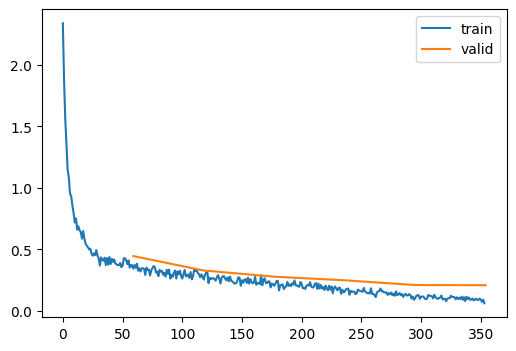

In [ ]:
learn.fit(epochs)

In [ ]:
def get_model4(act=act_gr, nfs=[16,32,64,128,256], norm=nn.BatchNorm2d):
    layers = [ResBlock(nfs[i], nfs[i+1], ks=3, act=act, stride=2, norm=norm) for i in range(len(nfs)-1)]
    model = nn.Sequential(
        conv(1, 16, ks=5, stride=1, act=act, norm=norm), *layers,
        GlobalAvgPool(), nn.Linear(nfs[-1], 10)
    )
    return model

In [ ]:
epochs = 6
lr = 0.01
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))

set_seed(1103, False)
model = get_model4()
model = model.apply(init_w)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[sched], opt_func=optim.AdamW)
learn.summary()

TOTAL: params=1224938, ~MFLOPs=13.3


|Module|Input|Output|Num params|~MFLOPS|
|-|-|-|-|-|
|Sequential|[1024, 1, 28, 28]|[1024, 16, 28, 28]|448|0.3|
|ResBlock|[1024, 16, 28, 28]|[1024, 32, 14, 14]|14560|2.8|
|ResBlock|[1024, 32, 14, 14]|[1024, 64, 7, 7]|57792|2.8|
|ResBlock|[1024, 64, 7, 7]|[1024, 128, 4, 4]|230272|3.7|
|ResBlock|[1024, 128, 4, 4]|[1024, 256, 2, 2]|919296|3.7|
|GlobalAvgPool|[1024, 256, 2, 2]|[1024, 256]|0|0.0|
|Linear|[1024, 256]|[1024, 10]|2570|0.0|


accuracy,loss,epoch,train
0.800,0.592,0,train
0.861,0.387,0,valid
0.888,0.306,1,train
0.895,0.294,1,valid
0.912,0.238,2,train
0.906,0.264,2,valid
0.926,0.195,3,train
0.915,0.242,3,valid
0.947,0.142,4,train
0.926,0.212,4,valid


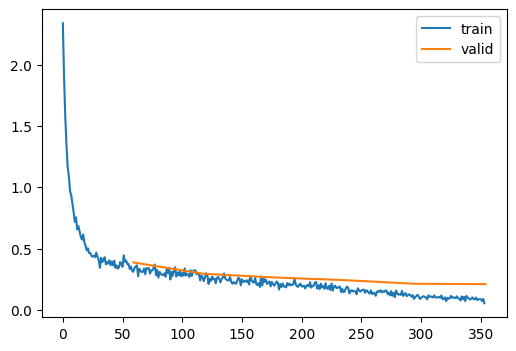

In [ ]:
learn.fit(epochs)

## Data augmentation

accuracy,loss,epoch,train
0.793,0.623,0,train
0.862,0.379,0,valid
0.889,0.304,1,train
0.882,0.317,1,valid
0.903,0.262,2,train
0.889,0.315,2,valid
0.913,0.234,3,train
0.893,0.306,3,valid
0.921,0.215,4,train
0.902,0.303,4,valid


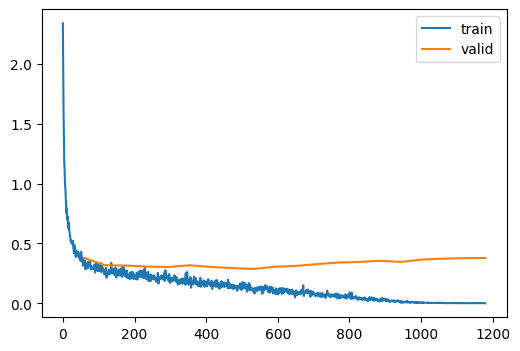

In [ ]:
epochs = 20
lr = 0.01
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))

set_seed(1103, False)
model = get_model4()
model = model.apply(init_w)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[sched], opt_func=optim.AdamW)
learn.fit(epochs)

#### Rescaled Weight Decay

In [ ]:
class RescaledAdamW(optim.AdamW):
    def __init__(self, model, bn_wd, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.ms = []
        self.bn_wd = bn_wd
        for m in model.modules():
            if type(m).__name__.find("Norm") != -1:
                self.ms.append(m)

    def step(self, closure=None):
        super().step(closure)
        # NOTE: To correctly handle param groups, this needs to be done separately for each pg
        lr = self.param_groups[0]["lr"]
        with torch.no_grad():
            for m in self.ms:
                # NOTE: We do not decay the averages
                m.bias.data = m.bias.data * (1. - lr * self.bn_wd)
                m.weight.data = m.weight.data - (m.weight.data - 1.) * lr * self.bn_wd

accuracy,loss,epoch,train
0.792,0.623,0,train
0.862,0.379,0,valid
0.889,0.304,1,train
0.882,0.318,1,valid
0.902,0.262,2,train
0.884,0.318,2,valid
0.913,0.235,3,train
0.893,0.321,3,valid
0.920,0.216,4,train
0.899,0.296,4,valid


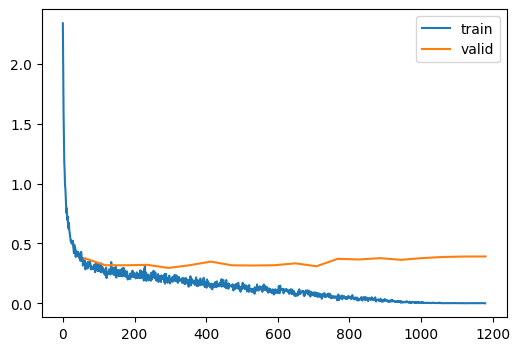

In [ ]:
epochs = 20
lr = 0.01
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))

set_seed(1103, False)
model = get_model4()
model = model.apply(init_w)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[sched], opt_func=partial(RescaledAdamW, model, 0.1, weight_decay =0.))
learn.fit(epochs)

accuracy,loss,epoch,train
0.792,0.623,0,train
0.862,0.379,0,valid
0.889,0.303,1,train
0.886,0.312,1,valid
0.903,0.261,2,train
0.879,0.342,2,valid
0.913,0.235,3,train
0.885,0.340,3,valid
0.920,0.217,4,train
0.901,0.301,4,valid


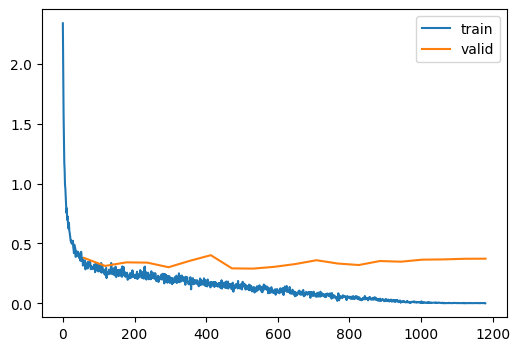

In [ ]:
epochs = 20
lr = 0.01
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))

set_seed(1103, False)
model = get_model4()
model = model.apply(init_w)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[sched], opt_func=partial(RescaledAdamW, model, 0.5, weight_decay =0.))
learn.fit(epochs)

accuracy,loss,epoch,train
0.792,0.624,0,train
0.863,0.379,0,valid
0.889,0.303,1,train
0.885,0.315,1,valid
0.904,0.259,2,train
0.888,0.315,2,valid
0.914,0.233,3,train
0.901,0.288,3,valid
0.919,0.219,4,train
0.897,0.308,4,valid


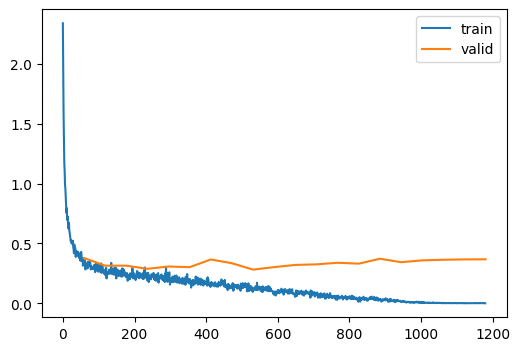

In [ ]:
epochs = 20
lr = 0.01
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))

set_seed(1103, False)
model = get_model4()
model = model.apply(init_w)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[sched], opt_func=partial(RescaledAdamW, model, 100, weight_decay =0.))
learn.fit(epochs)

accuracy,loss,epoch,train
0.792,0.623,0,train
0.862,0.379,0,valid
0.889,0.304,1,train
0.883,0.315,1,valid
0.904,0.260,2,train
0.892,0.300,2,valid
0.914,0.235,3,train
0.894,0.306,3,valid
0.920,0.216,4,train
0.892,0.341,4,valid


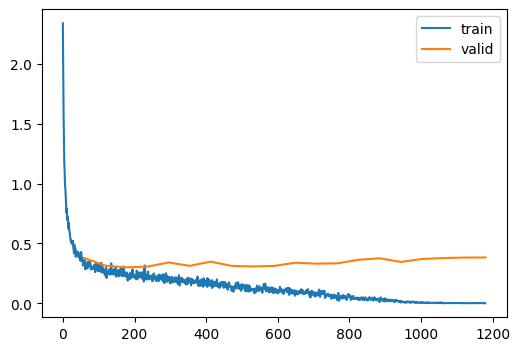

In [ ]:
epochs = 20
lr = 0.01
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))

set_seed(1103, False)
model = get_model4()
model = model.apply(init_w)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[sched], opt_func=partial(optim.AdamW,weight_decay =0.))
learn.fit(epochs)

accuracy,loss,epoch,train
0.793,0.624,0,train
0.864,0.378,0,valid
0.888,0.304,1,train
0.881,0.320,1,valid
0.903,0.262,2,train
0.893,0.297,2,valid
0.913,0.234,3,train
0.893,0.301,3,valid
0.916,0.224,4,train
0.895,0.298,4,valid


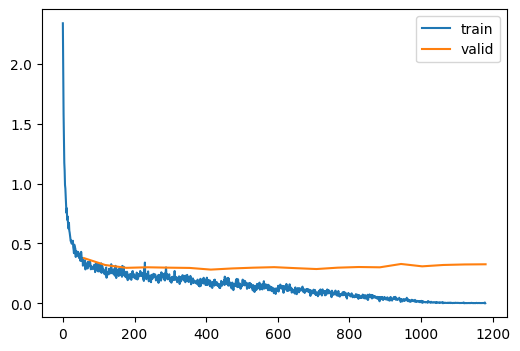

In [ ]:
epochs = 20
lr = 0.01
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))

set_seed(1103, False)
model = get_model4()
model = model.apply(init_w)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[sched], opt_func=partial(optim.AdamW,weight_decay=0.1))
learn.fit(epochs)

accuracy,loss,epoch,train
0.839,0.702,0,train
0.885,0.556,0,valid


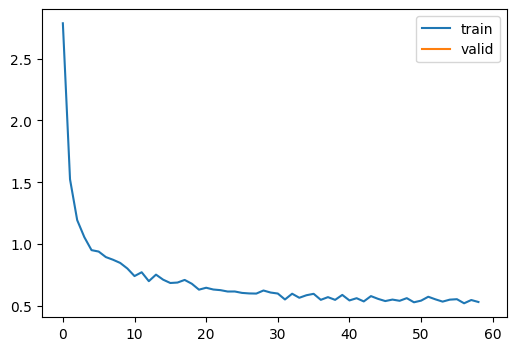

In [ ]:
def get_model4norm(act=act_gr, nfs=[16,32,64,128,256], norm=nn.BatchNorm2d):
    layers = [ResBlock(nfs[i], nfs[i+1], ks=3, act=act, stride=2, norm=norm) for i in range(len(nfs)-1)]
    model = nn.Sequential(
        conv(1, 16, ks=5, stride=1, act=act, norm=norm), *layers,
        GlobalAvgPool(), nn.Linear(nfs[-1], 10), nn.BatchNorm1d(10)
    )
    return model

epochs = 1
lr = 0.01
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))

set_seed(1103, False)
model = get_model4norm()
model = model.apply(init_w)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[sched], opt_func=partial(RescaledAdamW, model, 100, weight_decay =0.))
learn.fit(epochs)

In [ ]:
model[-1].weight, model[-1].bias

(Parameter containing:
 tensor([1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01, 1.01], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([ 0.00, -0.00,  0.00, -0.00,  0.00, -0.00,  0.00, -0.00, -0.00, -0.00], device='cuda:0', requires_grad=True))

accuracy,loss,epoch,train
0.793,0.624,0,train
0.863,0.378,0,valid
0.888,0.304,1,train
0.882,0.320,1,valid
0.903,0.262,2,train
0.880,0.321,2,valid
0.912,0.240,3,train
0.883,0.330,3,valid
0.919,0.220,4,train
0.894,0.317,4,valid


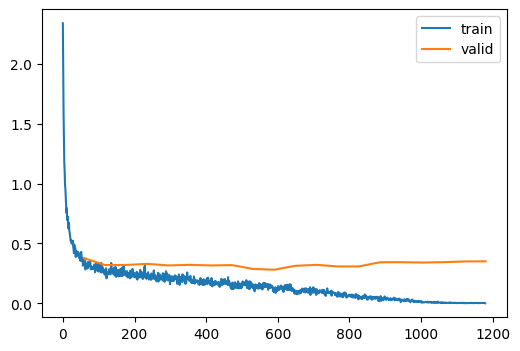

In [ ]:
epochs = 20
lr = 0.01
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))

set_seed(1103, False)
model = get_model4()
model = model.apply(init_w)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[sched], opt_func=partial(RescaledAdamW, model, 80, weight_decay=0.1))
learn.fit(epochs)

#### Augmentations

In [ ]:
def tfm_batch(b, tfm_x=fc.noop, tfm_y=fc.noop):
    return tfm_x(b[0]), tfm_y(b[1])

In [ ]:
from torchvision import transforms

In [ ]:
transforms.RandomCrop.__init__

<function torchvision.transforms.transforms.RandomCrop.__init__(self, size, padding=None, pad_if_needed=False, fill=0, padding_mode='constant')>

In [ ]:
transforms.RandomHorizontalFlip.__init__

<function torchvision.transforms.transforms.RandomHorizontalFlip.__init__(self, p=0.5)>

In [ ]:
transform = nn.Sequential(
    transforms.RandomCrop(size=28, padding=2),
    transforms.RandomHorizontalFlip()
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)
learn = TrainLearner(get_model4(), dls, F.cross_entropy, cbs=[SingleBatchCB(), augment])
learn.fit(1)

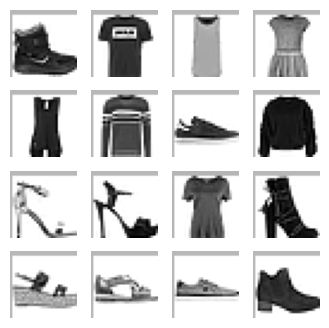

In [ ]:
show_images(learn.batch[0][:16], imsize=1)

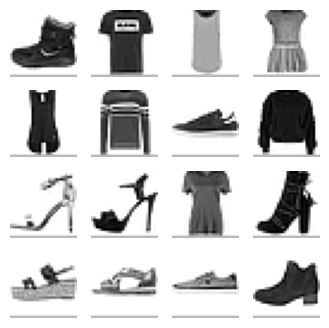

In [ ]:
learn.fit(1)
show_images(learn.batch[0][:16], imsize=1)

In [ ]:
cbs = [DeviceCB(), ProgressCB(True), MetricsCB(accuracy=MulticlassAccuracy())]

accuracy,loss,epoch,train
0.694,0.944,0,train
0.811,0.517,0,valid
0.837,0.442,1,train
0.825,0.470,1,valid
0.860,0.375,2,train
0.837,0.442,2,valid
0.879,0.330,3,train
0.869,0.362,3,valid
0.889,0.297,4,train
0.862,0.380,4,valid


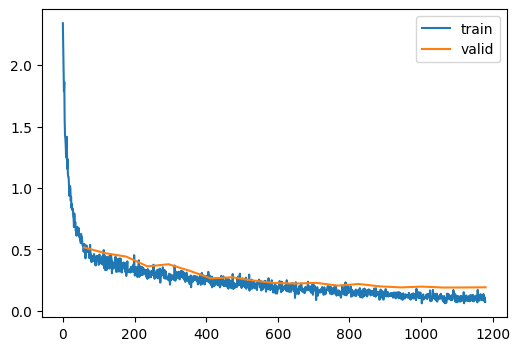

In [ ]:
epochs = 20
lr = 0.005
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))

transform = nn.Sequential(
    transforms.RandomCrop(size=28, padding=1),
    transforms.RandomHorizontalFlip()
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)
stats = ActivationStats(lambda x: isinstance(x, nn.Linear))

set_seed(1103, False)
model = get_model4()
model = model.apply(init_w)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[sched, augment, stats], opt_func=optim.AdamW)
learn.fit(epochs)

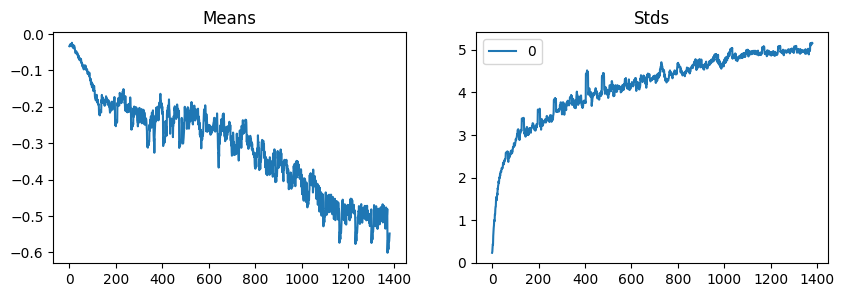

In [ ]:
stats.plot_stats()

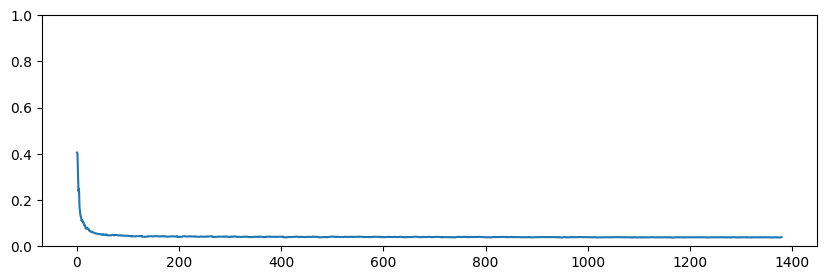

In [ ]:
stats.dead_chart()

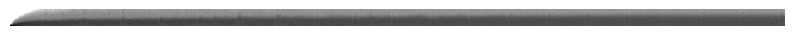

In [ ]:
stats.color_dim()

In [ ]:
def get_model5(act=act_gr, nfs=[16,32,64,128,256,512], norm=nn.BatchNorm2d):
    layers = [ResBlock(nfs[i], nfs[i+1], act=act, stride=2, norm=norm) for i in range(len(nfs)-1)]
    model = nn.Sequential(
        ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm), *layers,
        nn.Flatten(), nn.Linear(nfs[-1], 10), nn.BatchNorm1d(10)
    )
    return model

accuracy,loss,epoch,train
0.768,0.864,0,train
0.820,0.616,0,valid
0.857,0.590,1,train
0.819,0.580,1,valid
0.871,0.488,2,train
0.878,0.409,2,valid
0.883,0.400,3,train
0.866,0.423,3,valid
0.887,0.353,4,train
0.879,0.357,4,valid


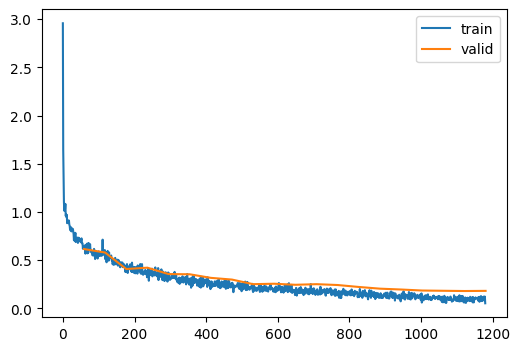

In [ ]:
epochs = 20
lr = 0.01
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))

transform = nn.Sequential(
    transforms.RandomCrop(size=28, padding=1),
    transforms.RandomHorizontalFlip()
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)
stats = ActivationStats(lambda x: isinstance(x, nn.Linear) or isinstance(x, nn.BatchNorm1d))

set_seed(1103, False)
model = get_model5()
model = model.apply(init_w)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[sched, augment, stats], opt_func=optim.AdamW)
learn.fit(epochs)

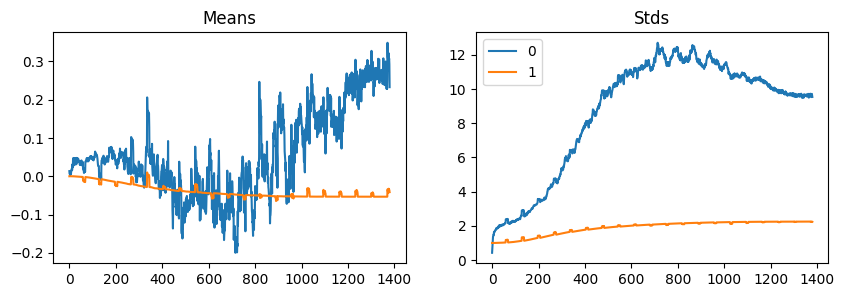

In [ ]:
stats.plot_stats()

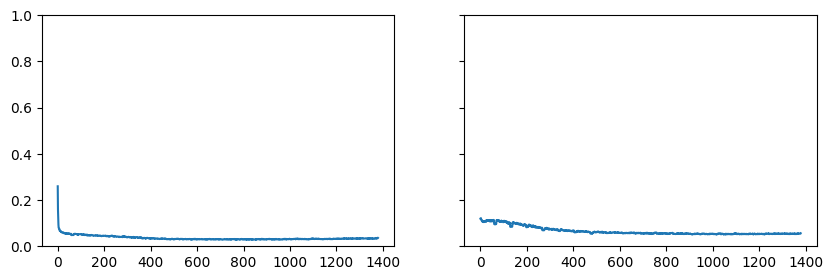

In [ ]:
stats.dead_chart()

In [ ]:
stats.color_dim()

In [ ]:
model_path = Path("models")
model_path.mkdir(exist_ok=True)
torch.save(learn.model, model_path / "14_aug.pkl")

## TTA

In [ ]:
#| export
class CapturePreds(Callback):
    def before_fit(self, learn):
        self.captured_inps = []
        self.captured_preds = []
        self.captured_targets = []

    def after_batch(self, learn):
        self.captured_preds.append(to_cpu(learn.preds))
        self.captured_inps.append(to_cpu(learn.batch[0]))
        self.captured_targets.append(to_cpu(learn.batch[1]))

accuracy,loss,epoch,train
0.938,0.183,0,valid


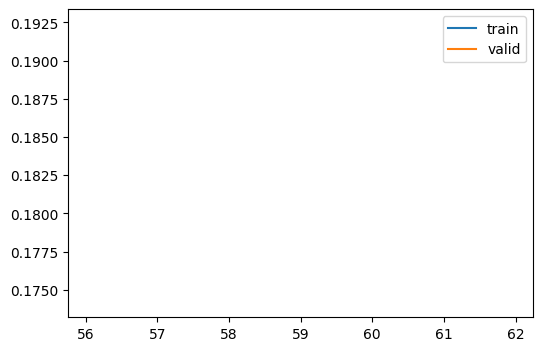

In [ ]:
preds1 = CapturePreds()
learn.fit(1, cbs=[preds1], train=False)

In [ ]:
TF.hflip?

Signature: TF.hflip(img: torch.Tensor) -> torch.Tensor
Docstring:
Horizontally flip the given image.

Args:
    img (PIL Image or Tensor): Image to be flipped. If img
        is a Tensor, it is expected to be in [..., H, W] format,
        where ... means it can have an arbitrary number of leading
        dimensions.

Returns:
    PIL Image or Tensor:  Horizontally flipped image.
File:      ~/miniforge3/envs/fastai/lib/python3.11/site-packages/torchvision/transforms/functional.py
Type:      function

accuracy,loss,epoch,train
0.941,0.184,0,valid


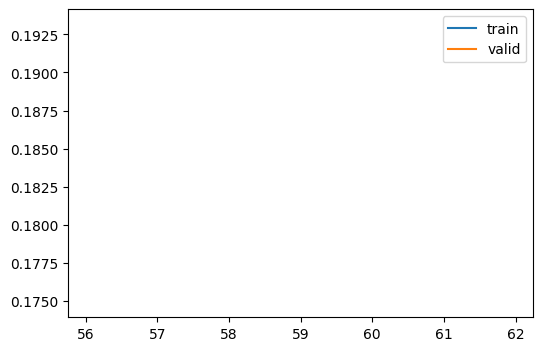

In [ ]:
preds2 = CapturePreds()
aug_tta = BatchTransformCB(partial(tfm_batch, tfm_x=TF.hflip), on_valid=True)
learn.fit(1, cbs=[preds2, aug_tta], train=False)

In [ ]:
tta_preds = torch.stack((torch.cat(preds1.captured_preds), torch.cat(preds2.captured_preds)))
tta_preds.shape

torch.Size([2, 10000, 10])

In [ ]:
tta_preds = tta_preds.mean(0)
tta_preds.shape

torch.Size([10000, 10])

In [ ]:
tta_preds = tta_preds.argmax(1)
tta_preds.shape

torch.Size([10000])

In [ ]:
targets = torch.cat(preds1.captured_targets)
targets.shape

torch.Size([10000])

In [ ]:
(tta_preds == targets).float().mean().item()

0.942300021648407

## Random erase

In [ ]:
xbs = xb[:16].clone()
xbs.shape

torch.Size([16, 1, 28, 28])

In [ ]:
xbs_mean = xbs.mean()
xbs_std = xbs.std()
xbs_min, xbs_max = xbs.min(), xbs.max()
xbs.mean(), xbs.std(), xbs.min(), xbs.max()

(tensor(-0.02), tensor(1.03), tensor(-0.80), tensor(2.06))

In [ ]:
torch.rand(1)

tensor([0.85])

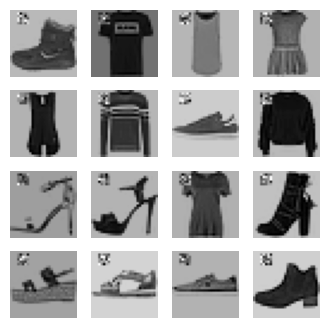

In [ ]:
set_seed(1103, False)
size = 0.2
start_x = int(torch.rand(1) * (1 - size) * xbs.shape[-2])
start_y = int(torch.rand(1) * (1 - size) * xbs.shape[-1])
size_x = int(size * xbs.shape[-2])
size_y = int(size * xbs.shape[-1])
init.normal_(xbs[:, :, start_x:start_x+size_x, start_y:start_y+size_y], mean=xbs_mean, std=xbs_std)
show_images(xbs, imsize=1)

In [ ]:
xbs.mean(), xbs.std(), xbs.min(), xbs.max()

(tensor(-0.00), tensor(1.03), tensor(-4.33), tensor(2.80))

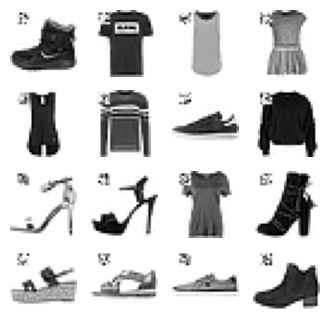

In [ ]:
show_images(torch.clamp(xbs, xbs_min, xbs_max), imsize=1)

In [ ]:
%timeit -n 500 torch.rand(2)
%timeit -n 500 random.random(); random.random()

3.17 µs ± 1.31 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
62.2 ns ± 3.52 ns per loop (mean ± std. dev. of 7 runs, 500 loops each)


In [ ]:
%timeit -n 100 torch.rand(1000)
%timeit -n 100 for i in range(1000): random.random()

16.6 µs ± 8.58 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
43.4 µs ± 3.53 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
#| export
def _rand_erase1(x, pct, xm, xs, mn, mx):
    start_x = int(random.random() * (1 - pct) * x.shape[-2])
    start_y = int(random.random() * (1 - pct) * x.shape[-1])
    size_x = int(pct * x.shape[-2])
    size_y = int(pct * x.shape[-1])
    init.normal_(x[:, :, start_x:start_x+size_x, start_y:start_y+size_y], mean=xm, std=xs)
    torch.clamp_(x, mn, mx)

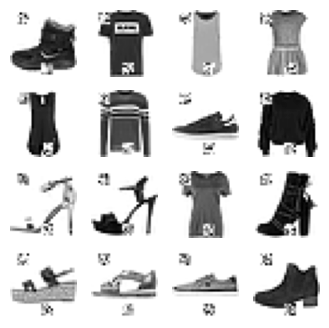

In [ ]:
_rand_erase1(xbs, size, xbs_mean, xbs_std, xbs_min, xbs_max)
show_images(xbs, imsize=1)

In [ ]:
#|export
def rand_erase(x, pct, max_num):
    xm,xs,mn,mx = x.mean(), x.std(), x.min(), x.max()
    num = random.randint(0, max_num)
    for i in range(num): _rand_erase1(x, pct, xm, xs, mn, mx)
    return x

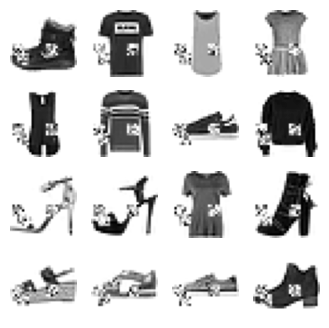

In [ ]:
set_seed(1103, False)
xbs = xb[:16].clone()
rand_erase(xbs, 0.2, 5)
show_images(xbs, imsize=1)

In [ ]:
#|export
class RandErase(nn.Module):
    def __init__(self, pct, max_num): super().__init__(); fc.store_attr()

    def forward(self, x):
        return rand_erase(x, self.pct, self.max_num)

accuracy,loss,epoch,train
0.742,0.929,0,train
0.801,0.639,0,valid
0.829,0.677,1,train
0.837,0.564,1,valid
0.850,0.597,2,train
0.847,0.536,2,valid
0.861,0.534,3,train
0.856,0.478,3,valid
0.865,0.489,4,train
0.846,0.477,4,valid


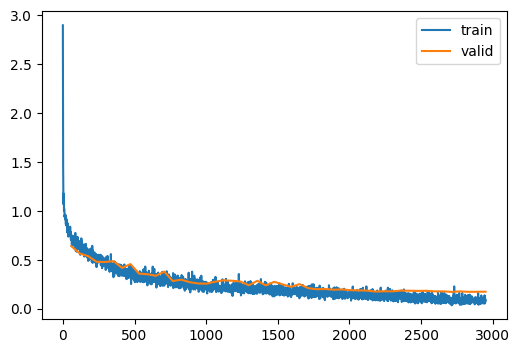

In [ ]:
epochs = 50
lr = 0.01
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))

transform = nn.Sequential(
    transforms.RandomCrop(size=28, padding=1),
    transforms.RandomHorizontalFlip(),
    RandErase(0.2, 5),
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

set_seed(1103, False)
model = get_model5()
model = model.apply(init_w)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[sched, augment], opt_func=optim.AdamW)
learn.fit(epochs)

## Random copy

In [ ]:
xbs = xb[:16].clone()

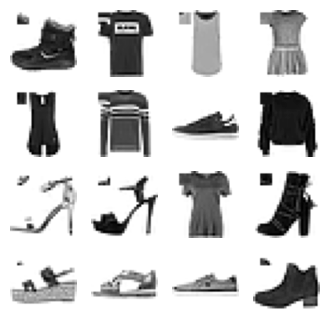

In [ ]:
set_seed(1103, False)
size = 0.2
start_x1 = int(torch.rand(1) * (1 - size) * xbs.shape[-2])
start_y1 = int(torch.rand(1) * (1 - size) * xbs.shape[-1])
start_x2 = int(torch.rand(1) * (1 - size) * xbs.shape[-2])
start_y2 = int(torch.rand(1) * (1 - size) * xbs.shape[-1])
size_x = int(size * xbs.shape[-2])
size_y = int(size * xbs.shape[-1])
xbs[:, :, start_x1:start_x1+size_x, start_y1:start_y1+size_y] = xbs[:, :, start_x2:start_x2+size_x, start_y2:start_y2+size_y]
show_images(xbs, imsize=1)

In [ ]:
#| export
def _rand_copy1(x, pct):
    start_x1 = int(torch.rand(1) * (1 - pct) * x.shape[-2])
    start_y1 = int(torch.rand(1) * (1 - pct) * x.shape[-1])
    start_x2 = int(torch.rand(1) * (1 - pct) * x.shape[-2])
    start_y2 = int(torch.rand(1) * (1 - pct) * x.shape[-1])
    size_x = int(pct * x.shape[-2])
    size_y = int(pct * x.shape[-1])
    x[:, :, start_x1:start_x1+size_x, start_y1:start_y1+size_y] = x[:, :, start_x2:start_x2+size_x, start_y2:start_y2+size_y]

In [ ]:
#|export
def rand_copy(x, pct, max_num):
    num = random.randint(0, max_num)
    for i in range(num): _rand_copy1(x, pct)
    return x

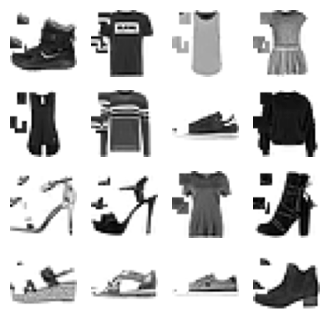

In [ ]:
xbs = xb[:16].clone()
set_seed(1103, False)
show_images(rand_copy(xbs, 0.2, 5), imsize=1)

In [ ]:
#|export
class RandCopy(nn.Module):
    def __init__(self, pct, max_num): super().__init__(); fc.store_attr()

    def forward(self, x):
        return rand_copy(x, self.pct, self.max_num)

accuracy,loss,epoch,train
0.736,0.947,0,train
0.814,0.597,0,valid
0.828,0.672,1,train
0.833,0.558,1,valid
0.837,0.600,2,train
0.849,0.471,2,valid
0.850,0.506,3,train
0.851,0.456,3,valid
0.857,0.454,4,train
0.854,0.424,4,valid


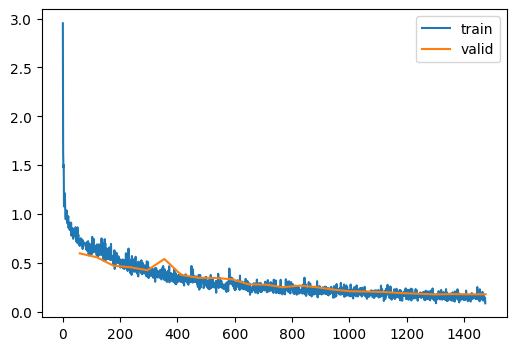

In [ ]:
epochs = 25
lr = 0.01
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))

transform = nn.Sequential(
    transforms.RandomCrop(size=28, padding=1),
    transforms.RandomHorizontalFlip(),
    RandCopy(0.2, 5),
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

set_seed(1103, False)
model = get_model5()
model = model.apply(init_w)
learn1 = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[sched, augment], opt_func=optim.AdamW)
learn1.fit(epochs)

accuracy,loss,epoch,train
0.735,0.949,0,train
0.815,0.617,0,valid
0.826,0.675,1,train
0.800,0.637,1,valid
0.844,0.577,2,train
0.839,0.499,2,valid
0.851,0.508,3,train
0.852,0.473,3,valid
0.856,0.451,4,train
0.832,0.494,4,valid


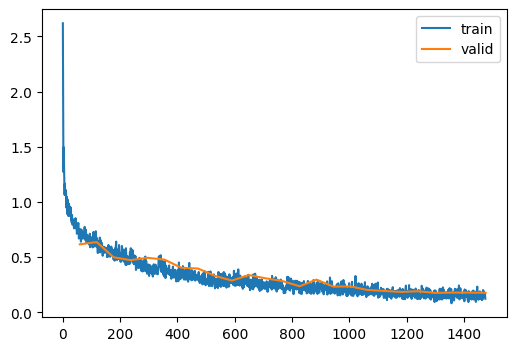

In [ ]:
epochs = 25
lr = 0.01
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))

transform = nn.Sequential(
    transforms.RandomCrop(size=28, padding=1),
    transforms.RandomHorizontalFlip(),
    RandCopy(0.2, 5),
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

set_seed(1104, False)
model = get_model5()
model = model.apply(init_w)
learn2 = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[sched, augment], opt_func=optim.AdamW)
learn2.fit(epochs)

accuracy,loss,epoch,train
0.939,0.179,0,valid


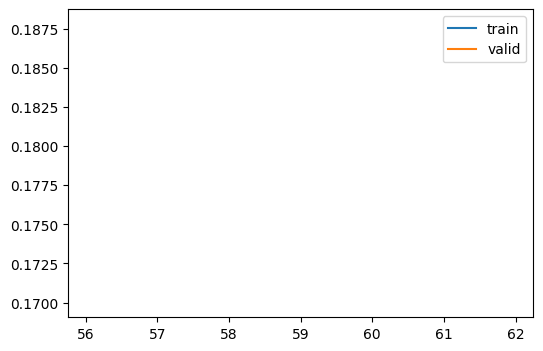

accuracy,loss,epoch,train
0.938,0.178,0,valid


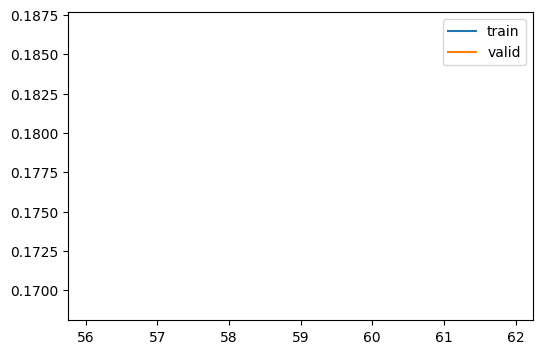

In [ ]:
capture1, capture2 = CapturePreds(), CapturePreds()
learn1.fit(1, cbs=[capture1], train=False)
learn2.fit(1, cbs=[capture2], train=False)

In [ ]:
preds = torch.stack((torch.cat(capture1.captured_preds), torch.cat(capture2.captured_preds))).mean(0).argmax(1)
targets = torch.cat(capture1.captured_targets)
(preds == targets).float().mean().item()

0.9412999749183655

## Random Swap

In [ ]:
#| export

def get_rand_rect_start(x, pct):
    return (
        int(torch.rand(1) * (1 - pct) * x.shape[-2]),
        int(torch.rand(1) * (1 - pct) * x.shape[-1])
    )

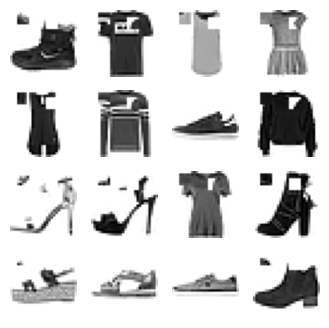

In [ ]:
set_seed(1103, False)
xbs = xb[:16].clone()
pct = 0.2
start_x1, start_y1 = get_rand_rect_start(xbs, pct)
start_x2, start_y2 = get_rand_rect_start(xbs, pct)
size_x = int(pct * xbs.shape[-2])
size_y = int(pct * xbs.shape[-1])
p1 = xbs[:, :, start_x1:start_x1+size_x, start_y1:start_y1+size_y].clone()
p2 = xbs[:, :, start_x2:start_x2+size_x, start_y2:start_y2+size_y].clone()
xbs[:, :, start_x1:start_x1+size_x, start_y1:start_y1+size_y] = p2
xbs[:, :, start_x2:start_x2+size_x, start_y2:start_y2+size_y] = p1
show_images(xbs, imsize=1)

In [ ]:
#| export
def _rand_swap1(x, pct):
    start_x1, start_y1 = get_rand_rect_start(x, pct)
    start_x2, start_y2 = get_rand_rect_start(x, pct)
    size_x = int(pct * x.shape[-2])
    size_y = int(pct * x.shape[-1])
    p1 = x[:, :, start_x1:start_x1+size_x, start_y1:start_y1+size_y].clone()
    p2 = x[:, :, start_x2:start_x2+size_x, start_y2:start_y2+size_y].clone()
    x[:, :, start_x1:start_x1+size_x, start_y1:start_y1+size_y] = p2
    x[:, :, start_x2:start_x2+size_x, start_y2:start_y2+size_y] = p1

In [ ]:
#|export
def rand_swap(x, pct, max_num):
    num = random.randint(0, max_num)
    for i in range(num): _rand_swap1(x, pct)
    return x

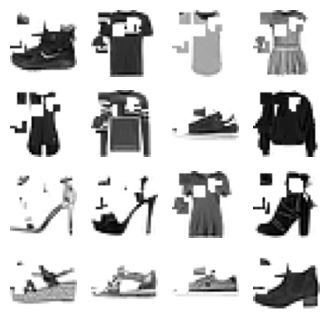

In [ ]:
xbs = xb[:16].clone()
set_seed(1103, False)
show_images(rand_swap(xbs, 0.2, 5), imsize=1)

In [ ]:
#|export
class RandSwap(nn.Module):
    def __init__(self, pct, max_num): super().__init__(); fc.store_attr()

    def forward(self, x):
        return rand_swap(x, self.pct, self.max_num)

accuracy,loss,epoch,train
0.705,1.024,0,train
0.795,0.646,0,valid
0.800,0.749,1,train
0.784,0.661,1,valid
0.816,0.690,2,train
0.807,0.619,2,valid
0.831,0.612,3,train
0.854,0.492,3,valid
0.837,0.564,4,train
0.824,0.522,4,valid


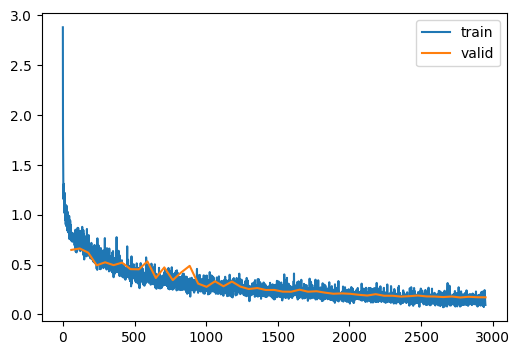

In [ ]:
epochs = 50
lr = 0.01
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))

transform = nn.Sequential(
    transforms.RandomCrop(size=28, padding=1),
    transforms.RandomHorizontalFlip(),
    RandSwap(0.2, 5),
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

set_seed(1103, False)
model = get_model5().apply(init_w)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[sched, augment], opt_func=optim.AdamW)
learn.fit(epochs)

## Dropout

In [ ]:
set_seed(1103, False)
distributions.binomial.Binomial(probs=0.8).sample((20,))

tensor([1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1.])

In [ ]:
distributions.binomial.Binomial?

Init signature:
distributions.binomial.Binomial(
    total_count=1,
    probs=None,
    logits=None,
    validate_args=None,
)
Docstring:     
Creates a Binomial distribution parameterized by :attr:`total_count` and
either :attr:`probs` or :attr:`logits` (but not both). :attr:`total_count` must be
broadcastable with :attr:`probs`/:attr:`logits`.

Example::

    >>> # xdoctest: +IGNORE_WANT("non-deterinistic")
    >>> m = Binomial(100, torch.tensor([0 , .2, .8, 1]))
    >>> x = m.sample()
    tensor([   0.,   22.,   71.,  100.])

    >>> m = Binomial(torch.tensor([[5.], [10.]]), torch.tensor([0.5, 0.8]))
    >>> x = m.sample()
    tensor([[ 4.,  5.],
            [ 7.,  6.]])

Args:
    total_count (int or Tensor): number of Bernoulli trials
    probs (Tensor): Event probabilities
    logits (Tensor): Event log-odds
File:           ~/miniforge3/envs/fastai/lib/python3.11/site-packages/torch/distributions/binomial.py
Type:           type
Subclasses:     

In [ ]:
class Dropout(nn.Module):
    def __init__(self, p):
        super().__init__()
        self.p = 1 - p
        self.mult = 1 / self.p

    def forward(self, x):
        if not self.training:
            return x
        dist = distributions.binomial.Binomial(tensor(1., device=x.device), probs=self.p)
        return x * dist.sample(x.shape) * self.mult

In [ ]:
drop = Dropout(0.2)
print(drop(torch.ones(10,)))
drop.eval()
print(drop(torch.ones(10,)))

tensor([1.25, 0.00, 1.25, 0.00, 1.25, 1.25, 1.25, 1.25, 1.25, 1.25])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


In [ ]:
def get_model6(act=act_gr, nfs=[16,32,64,128,256,512], norm=nn.BatchNorm2d, p_drop=0.2):
    layers = [ResBlock(nfs[i], nfs[i+1], act=act, stride=2, norm=norm) for i in range(len(nfs)-1)]
    model = nn.Sequential(
        ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm), nn.Dropout2d(p_drop),
        *layers,
        nn.Flatten(), Dropout(p_drop),
        nn.Linear(nfs[-1], 10), nn.BatchNorm1d(10)
    )
    return model

accuracy,loss,epoch,train
0.718,0.971,0,train
0.769,0.706,0,valid
0.817,0.593,1,train
0.828,0.493,1,valid
0.842,0.474,2,train
0.860,0.407,2,valid
0.871,0.380,3,train
0.892,0.315,3,valid
0.883,0.340,4,train
0.897,0.300,4,valid


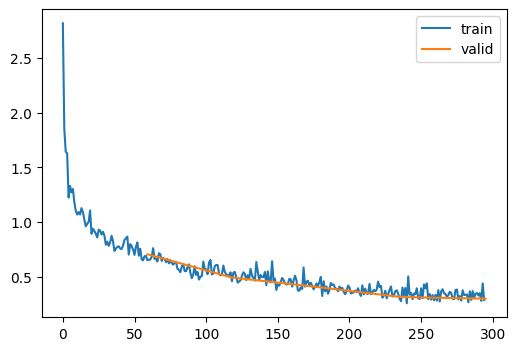

In [ ]:
epochs = 5
lr = 0.01
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))

transform = nn.Sequential(
    transforms.RandomCrop(size=28, padding=1),
    transforms.RandomHorizontalFlip(),
    RandCopy(0.2, 5),
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

set_seed(1103, False)
model = get_model6()
model = model.apply(init_w)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[sched, augment], opt_func=optim.AdamW)
learn.fit(epochs)

## Augment 2

In [ ]:
@inplace
def transformi(b):
    b["image"] = [(TF.to_tensor(i) * 2. - 1.) for i in b["image"]]
dst = ds.with_transform(transformi)

bs = 1024
dls = DataLoaders.from_dd(dst, bs)
xb, yb = next(iter(dls.train))

accuracy,loss,epoch,train
0.763,0.876,0,train
0.822,0.638,0,valid
0.854,0.598,1,train
0.844,0.526,1,valid
0.873,0.486,2,train
0.881,0.399,2,valid
0.881,0.405,3,train
0.835,0.492,3,valid
0.886,0.353,4,train
0.880,0.359,4,valid


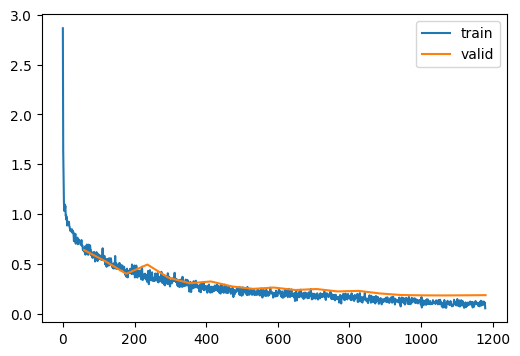

In [ ]:
epochs = 20
lr = 0.01
tmax = epochs * len(dls.train)
sched = BatchSchedCB(partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax))

transform = nn.Sequential(
    transforms.RandomCrop(size=28, padding=1),
    transforms.RandomHorizontalFlip()
)
augment = BatchTransformCB(partial(tfm_batch, tfm_x=transform), on_valid=False)

set_seed(1103, False)
model = get_model5()
model = model.apply(init_w)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+[sched, augment], opt_func=optim.AdamW)
learn.fit(epochs)

In [ ]:
model_path = Path("models")
model_path.mkdir(exist_ok=True)
torch.save(learn.model, model_path / "14_aug_for_fid.pkl")

# Export

In [ ]:
import nbdev; nbdev.nbdev_export()